# Evaluate Model


In [1]:
import os

import geopandas
import imageio
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import coo_matrix
import torch
import torch.nn.functional as F
from tqdm.notebook import tqdm

import _fix_paths
from lib.data import PEMSBay
from lib.models import STGCN_VAE
from lib import vis

## Define Constants


In [2]:
EXPERIMENT_NAME = 'x_start_decoder'
HIST_WINDOW = 12
PRED_WINDOW = 12
TEMPORAL_KERNEL = 3
SPATIAL_KERNEL = 3
ENCODER_LAYERS = [(HIST_WINDOW + PRED_WINDOW, 16, 64), (64, 32, 128)]
DECODER_LAYERS = [1, 16, 32]
RANDOM_SEED = 17

In [3]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Load Dataset


In [5]:
test_set = PEMSBay('../datasets/PEMS-BAY', 'test', HIST_WINDOW, PRED_WINDOW)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/io/pytables.py:3007: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  index = factory(


In [6]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False, drop_last=True)

In [7]:
test_data = {
    'data_loader': test_loader,
    'edge_idx': test_set.edge_idx.to(device),
    'edge_wt': test_set.edge_wt.to(device),
}

## Load Trained Model


In [8]:
model = STGCN_VAE(SPATIAL_KERNEL, TEMPORAL_KERNEL, HIST_WINDOW, PRED_WINDOW, ENCODER_LAYERS, DECODER_LAYERS)
model.load_state_dict(torch.load(f"../weights/{EXPERIMENT_NAME}.pt"))
model = model.to(device)

In [9]:
def eval(model, data):
    data_loader = data.get('data_loader', None)
    edge_idx = data.get('edge_idx', None)
    edge_wt = data.get('edge_wt', None)
    model.eval()
    mae, rmse, = torch.tensor([0.0]), torch.tensor([0.0])
    with torch.no_grad():
        for x, y in tqdm(data_loader):
            x, y = x.to(device), y.to(device)
            y_hat = model.decode(torch.randn(1, 1, test_set.num_vertices, 1), None, x, edge_idx, edge_wt)
            mae += (y_hat - y).abs().mean()
            rmse += (y_hat - y).pow(2).mean()
        mae /= len(data_loader)
        rmse = (rmse / len(data_loader)).sqrt()
    return mae.item(), rmse.item()

In [10]:
mae, rmse = eval(model, test_data)
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

  0%|          | 0/325 [00:00<?, ?it/s]

MAE: 3.5459
RMSE: 5.5596


## Visualize Predictions


In [11]:
x, y = next(iter(test_loader))
x, y = x.to(device), y.to(device)
z = torch.randn(1, 1, test_set.num_vertices, 1)
y_hat = model.decode(z, None, x, test_data['edge_idx'], test_data['edge_wt'])

In [12]:
# distance_df = pd.read_csv('../datasets/PEMS-BAY/distances.csv', names=['sensor_src','sensor_dst','distance'])
sensors_df = pd.read_csv('../datasets/PEMS-BAY/sensor_locations.csv', names=['sensor_id', 'latitude', 'longitude'])
sensors_gdf = geopandas.GeoDataFrame(
    sensors_df, geometry=geopandas.points_from_xy(sensors_df.longitude, sensors_df.latitude, crs="EPSG:4326")
)

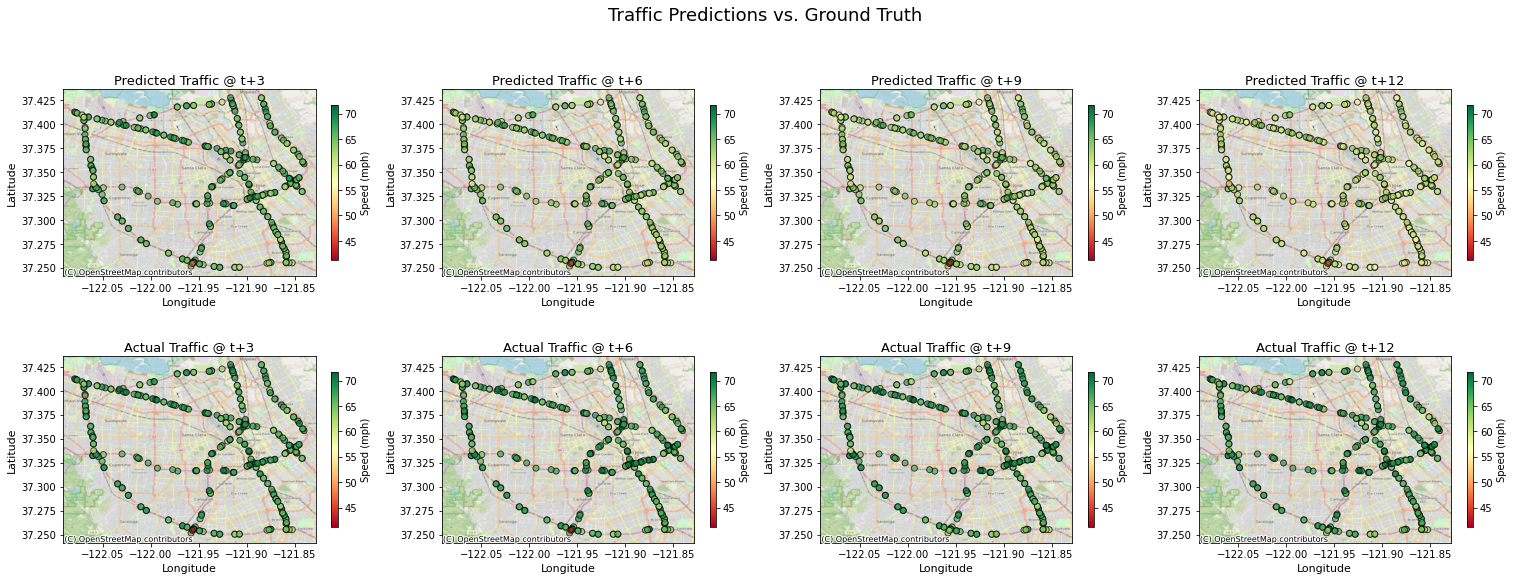

In [13]:
t_step = 3
preds = y_hat.detach().numpy().reshape(test_set.num_vertices, PRED_WINDOW)
gt = y.detach().numpy().reshape(test_set.num_vertices, PRED_WINDOW)
fig, ax = plt.subplots(2, PRED_WINDOW // t_step, figsize=(26, 9))
for i in range(PRED_WINDOW // t_step):
    t = i * t_step + 2
    vis.draw_traffic_plot(
        sensors_gdf,
        preds[:, t],
        ax=ax[0, i],
        title=f"Predicted Traffic @ t+{t+1}",
        titlesize=13,
        labelsize=11,
        vmin=preds.min(),
        vmax=preds.max()
    )
    vis.draw_traffic_plot(
        sensors_gdf,
        gt[:, t],
        ax=ax[1, i],
        title=f"Actual Traffic @ t+{t+1}",
        titlesize=13,
        labelsize=11,
        vmin=preds.min(),
        vmax=preds.max()
    )
fig.suptitle("Traffic Predictions vs. Ground Truth", fontsize=18)
plt.savefig(f"../figures/pred_v_gt_{EXPERIMENT_NAME}.png")
plt.show()

## Latent Space Visualization


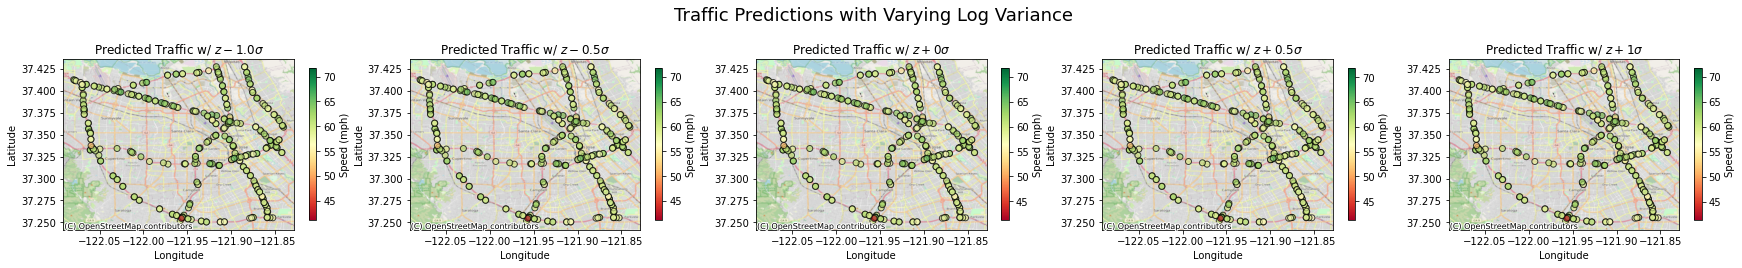

In [14]:
std = torch.randn(1, 1, test_set.num_vertices, 1)
fig, ax = plt.subplots(1, 5, figsize=(30, 4))
t = 12
ys = []
for i, C in enumerate((-1., -0.5, 0, 0.5, 1)):
    y_hat = model.decode(z, C * std, x, test_data['edge_idx'], test_data['edge_wt'])
    ys.append(y_hat)
    preds = y_hat.detach().numpy().reshape(test_set.num_vertices, PRED_WINDOW)

    vis.draw_traffic_plot(
        sensors_gdf,
        preds[:, -1],
        ax=ax[i],
        title=f"Predicted Traffic w/ $z {('+' if C >= 0 else '')}{C}\sigma$",
        titlesize=12,
        labelsize=10,
        aspect=20,
        vmin=preds.min(),
        vmax=preds.max()
    )
fig.suptitle("Traffic Predictions with Varying Log Variance", fontsize=18)
plt.savefig(f"../figures/latent_space_{EXPERIMENT_NAME}.png")
plt.show()

In [15]:
y_hat = model.decode(z, None, x, test_data['edge_idx'], test_data['edge_wt'])
preds = y_hat.detach().numpy().reshape(test_set.num_vertices, PRED_WINDOW)

In [16]:
for i in range(11):
    print(F.l1_loss(y_hat[:,:,:,i], y_hat[:,:,:,i+1]))

tensor(0.2888, grad_fn=<L1LossBackward0>)
tensor(0.7905, grad_fn=<L1LossBackward0>)
tensor(0.3762, grad_fn=<L1LossBackward0>)
tensor(0.6529, grad_fn=<L1LossBackward0>)
tensor(0.7867, grad_fn=<L1LossBackward0>)
tensor(0.3390, grad_fn=<L1LossBackward0>)
tensor(0.3891, grad_fn=<L1LossBackward0>)
tensor(0.4650, grad_fn=<L1LossBackward0>)
tensor(0.7793, grad_fn=<L1LossBackward0>)
tensor(0.4204, grad_fn=<L1LossBackward0>)
tensor(0.7641, grad_fn=<L1LossBackward0>)


## Create Prediction GIF

In [17]:
pred_files = []
for t in range(12):
    pred_file = os.path.join("../figures/", f"pred_{t}.png")
    vis.draw_traffic_plot(
        sensors_gdf, preds[:, t], title=f"Predicted Traffic @ t+{(t+1)*5}min", titlesize=13, labelsize=11, vmin=preds.min(), vmax=preds.max()
    )
    plt.savefig(pred_file)
    plt.close()
    pred_files.append(pred_file)

with imageio.get_writer('../figures/predictions.gif', mode='I') as writer:
    for filename in pred_files:
        image = imageio.imread(filename)
        writer.append_data(image)

for filename in pred_files:
    os.remove(filename)